<a href="https://colab.research.google.com/github/tsubauaaa/Tensorflow2.0-tutorials/blob/master/Tensorflow2_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 回帰：燃費を予測する
回帰問題では、価格や確率といった連続的な値の出力を予測することが目的となる。これは、分類問題の目的が、（例えば、写真にリンゴが写っているかオレンジが写っているかといった）離散的なラベルを予測することであるのとは対照的。

このノートブックでは、古典的なAuto MPGデータセットを使用し、1970年代後半から1980年台初めの自動車の燃費を予測するモデルを構築する。この目的のため、モデルにはこの時期の多数の自動車の仕様を読み込ませる。仕様には、気筒数、排気量、馬力、重量などが含まる。

In [0]:
# ペアプロットのためseabornを使用する
!pip install -q seaborn

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
!pip install tensorflow-gpu==2.0.0
try:
  # Colab only
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras

from tensorflow.keras import layers

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

     |████████████████████████████████| 380.8MB 65kB/s 
     |████████████████████████████████| 450kB 62.7MB/s 
     |████████████████████████████████| 3.8MB 58.6MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=b710934a7a1d0cdd6e5b258c6d8d1efa9dde3bc5cce183986ba644f4da33a981
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 1.14.0 has requirement tensorboard<1.15.0,>=1.14.0, but you'll have tensorboard 2.0.0 which is incompatible.
ERROR: tensorflow 1.14.0 has requirement tensorflow-estimator<1.15.0rc0,>=1.14.0rc0, but you'll have tensorflow-estimator 2.0.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.14.0
    Uninstalling tensorflow-estimator-1.14.0:
      Successfully uninstalled tensorflow-estimator-1.14.0
  Found existing installation: gast 0.3.2
    Uninstalling gast-0.3.2:
      Successfully uninstalled gast-0.3.2


### Auto MPG データセット
このデータセットはUCI Machine Learning Repositoryから入手可能。

データの取得
まず、データセットをダウンロードする。

In [3]:
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 4us/step


'/root/.keras/datasets/auto-mpg.data'

pandasを使ってデータをインポートする。

In [4]:
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower','Weight', 'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                          na_values = "?", comment='\t',
                          sep=" ", skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### データのクレンジング
このデータには、いくつか欠損値がある。

In [5]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

この最初のチュートリアルでは簡単化のためこれらの行を削除する。

In [0]:
dataset = dataset.dropna()

"Origin"の列は数値ではなくカテゴリー。このため、ワンホットエンコーディングを行う。

In [0]:
origin = dataset.pop('Origin')

In [8]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


### データを訓練用セットとテスト用セットに分割
データセットを訓練用セットとテスト用セットに分割する。

テスト用データセットは、作成したモデルの最終評価に使用する。

In [0]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### データの観察
訓練用セットのいくつかの列の組み合わせの同時分布を見てみる。

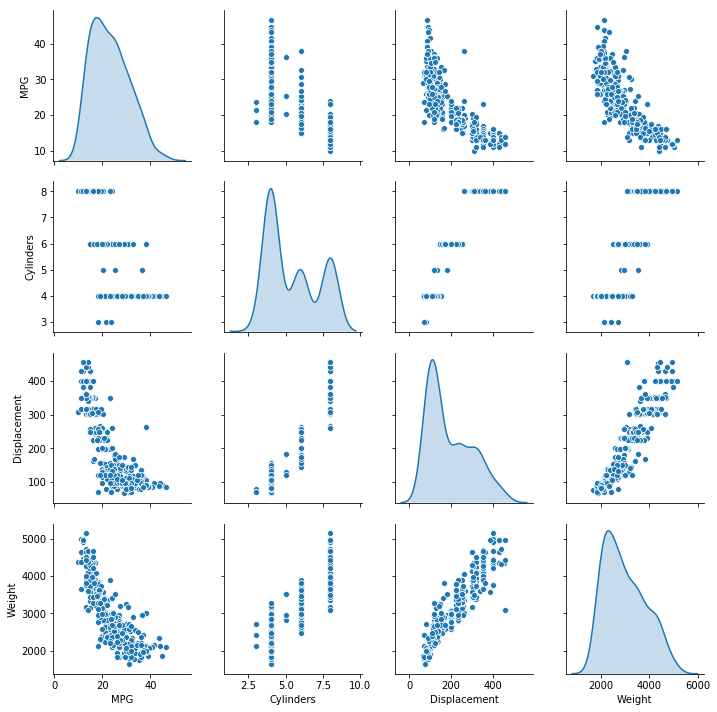

In [10]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

全体の統計値も見てみる

In [11]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


### ラベルと特徴量の分離
ラベル、すなわち目的変数を特徴量から切り離す。このラベルは、モデルに予測させたい数量。

In [0]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### データの正規化
上のtrain_statsのブロックをもう一度見て、それぞれの特徴量の範囲がどれほど違っているかに注目する。

スケールや値の範囲が異なる特徴量を正規化するのは良い習慣。特徴量の正規化なしでもモデルは収束するが、モデルの訓練はより難しくなり、結果として得られたモデルも入力で使われる単位に依存する。

注：（正規化に使用する）統計量は意図的に訓練用データセットだけを使って算出しているが、これらはテスト用データセットの正規化にも使う。テスト用のデータセットを、モデルの訓練に使用した分布と同じ分布に射影する必要がある。

In [0]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

この正規化したデータを使ってモデルを訓練する。

注意：ここで入力の正規化に使った統計量（平均と標準偏差）は、先程実施したワンホットエンコーディングとともに、モデルに供給する他のどんなデータにも適用する必要がある。テスト用データセットだけでなく、モデルを本番で使用する際の生のデータも同様。

### モデル
#### モデルの構築
それではモデルを構築する。ここでは、2つの全結合の隠れ層と、1つの連続値を返す出力層からなる、Sequentialモデルを使う。モデルを構築するステップはbuild_modelという1つの関数の中に組み込む。あとから2つ目のモデルを構築するため。

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [0]:
model = build_model()

### モデルの検証
.summaryメソッドを使って、モデルの簡単な説明を表示する。

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


では、モデルを試してみる。訓練用データのうち10個のサンプルからなるバッチを取り出し、それを使ってmodel.predictメソッドを呼び出す。

In [17]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.32297122],
       [ 0.06833929],
       [ 0.67997545],
       [ 0.28096378],
       [ 0.06923256],
       [-0.11772408],
       [ 0.08471748],
       [ 0.17946017],
       [-0.12994388],
       [ 0.28904188]], dtype=float32)

うまく動作している。予定通りの型と形状の出力が得られている。

### モデルの訓練
モデルを1000エポック訓練し、訓練と検証の正解率をhistoryオブジェクトに記録する。

In [18]:
# エポックが終わるごとにドットを１つ出力することで進捗を表示
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split=0.2, verbose=0,
    callbacks=[PrintDot()]
)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

historyオブジェクトに保存された数値を使ってモデルの訓練の様子を可視化する。

In [19]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.974506,1.100798,2.974506,9.131851,2.274553,9.131851,995
996,3.045098,1.146644,3.045098,9.145103,2.228405,9.145103,996
997,2.864328,1.110073,2.864328,9.747205,2.336104,9.747206,997
998,3.077485,1.142208,3.077485,9.008616,2.240996,9.008616,998
999,2.947493,1.107281,2.947493,8.636916,2.172918,8.636916,999


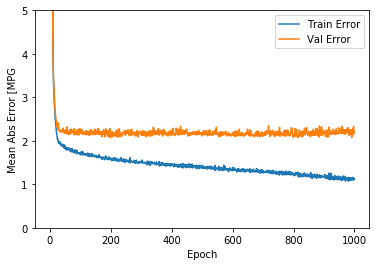

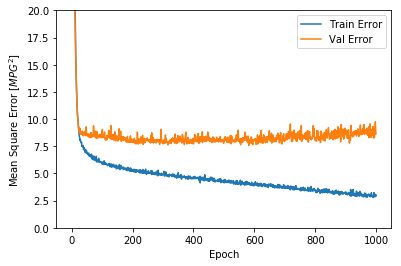

In [20]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label = 'Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

このグラフを見ると、検証エラーは100エポックを過ぎたあたりで改善が見られなくなり、むしろ悪化している。検証スコアの改善が見られなくなったら自動的に訓練を停止するように、model.fitメソッド呼び出しを変更する。ここでは、エポック毎に訓練状態をチェックするEarlyStoppingコールバックを使用する。設定したエポック数の間に改善が見られない場合、訓練を自動的に停止する。


...............................................

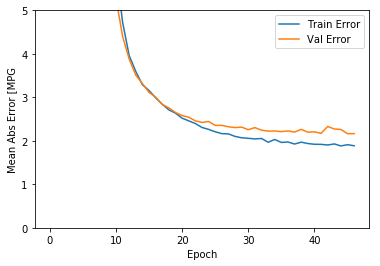

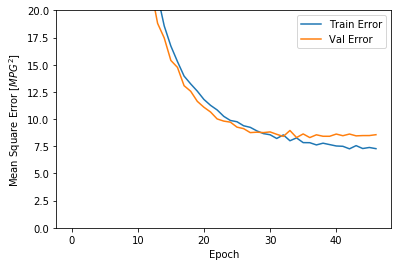

In [21]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])
plot_history(history)

検証用データセットでのグラフを見ると、平均誤差は+/- 2 MPG（マイル/ガロン）前後。

モデルの訓練に使用していないテスト用データセットを使って、モデルがどれくらい汎化できているか見てみる。これによって、モデルが実際の現場でどれくらい正確に予測できるかがわかる。

In [22]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  1.98 MPG


### モデルを使った予測
最後に、テストデータを使ってMPG値を予測する。

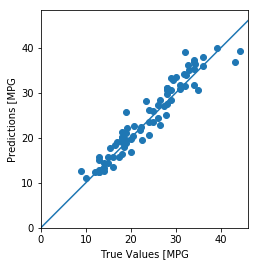

In [23]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG')
plt.ylabel('Predictions [MPG')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

そこそこ良い予測ができているように見える。誤差の分布を見てみる。

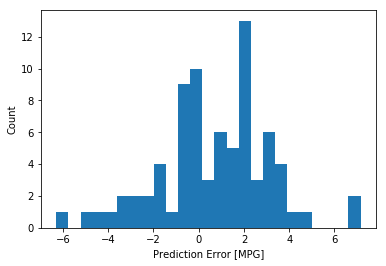

In [24]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

とても正規分布には見えないが、サンプル数が非常に小さいからだと考えられる。

### 結論
このノートブックでは、回帰問題を扱うためのテクニックをいくつか紹介した。

* 平均二乗誤差（MSE: Mean Squared Error）は回帰問題に使われる一般的な損失関数（分類問題には異なる損失関数が使われる）。
* 同様に、回帰問題に使われる評価指標も分類問題とは異なる。回帰問題の一般的な評価指標は平均絶対誤差（MAE: Mean Absolute Error）。
* 入力数値特徴量の範囲が異なっている場合、特徴量毎に同じ範囲に正規化するべき。
* 訓練用データが多くない場合、過学習を避けるために少ない隠れ層を持つ小さいネットワークを使うというのが良い方策の1つ。
* Early Stoppingは過学習を防止するための便利な手法の一つ。